<a href="https://colab.research.google.com/github/nirmal-naraianan-s/traffic-sign-predictor/blob/main/Traffic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [84]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import pickle
import random
import pandas as pd
import cv2
from keras.datasets import mnist
from keras.layers import Dense
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Dropout
from keras.models import Model
np.random.seed(0)

In [85]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.


In [86]:
!ls german-traffic-signs

signnames.csv  test.p  train.p	valid.p


In [87]:
with open('german-traffic-signs/train.p','rb') as f:
  train_data = pickle.load(f)
with open('german-traffic-signs/test.p','rb') as f:
  test_data = pickle.load(f)
with open('german-traffic-signs/valid.p','rb') as f:
  val_data = pickle.load(f)

In [88]:
X_train, Y_train = train_data['features'],train_data['labels']
X_test, Y_test = test_data['features'],test_data['labels']
X_val, Y_val = val_data['features'],val_data['labels']
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(34799, 32, 32, 3)
(12630, 32, 32, 3)
(4410, 32, 32, 3)


In [89]:
assert(X_train.shape[0] == Y_train.shape[0]),"Labels not equal to number of images"
assert(X_test.shape[0] == Y_test.shape[0]),"Labels not equal to number of images"
assert(X_val.shape[0] == Y_val.shape[0]),"Labels not equal to number of images"
assert(X_train.shape[1:])==(32,32,3),"Dimension error"
assert(X_test.shape[1:])==(32,32,3),"Dimension error"
assert(X_val.shape[1:])==(32,32,3),"Dimension error"

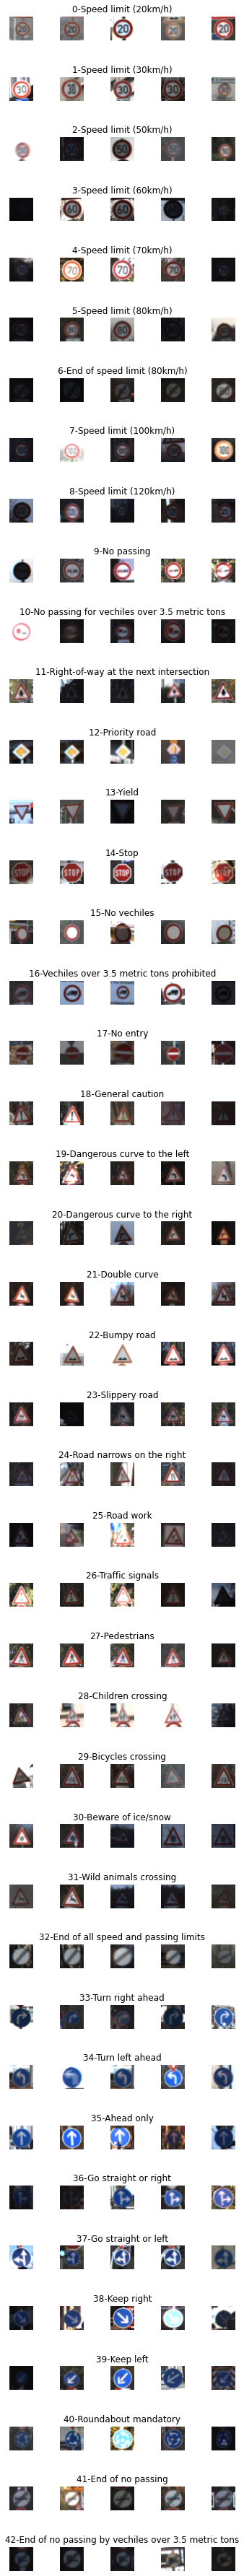

In [90]:
data = pd.read_csv('german-traffic-signs/signnames.csv')
num_of_samples = []
cols = 5
num_classes = 43

fig,axis = plt.subplots(nrows=num_classes,ncols=cols,figsize=(5,50))
fig.tight_layout()
for i in range(cols):
    for j,row in data.iterrows():
         x_selected = X_train[Y_train==j]
         axis[j][i].imshow(x_selected[random.randint(0,len(x_selected)-1),:,:],cmap = plt.get_cmap("gray"))
         axis[j][i].axis("off")
         if i==2:
             axis[j][i].set_title(str(j)+'-'+row["SignName"])
             num_of_samples.append(len(x_selected))


Text(0.5, 1.0, 'Distribution of training dataset')

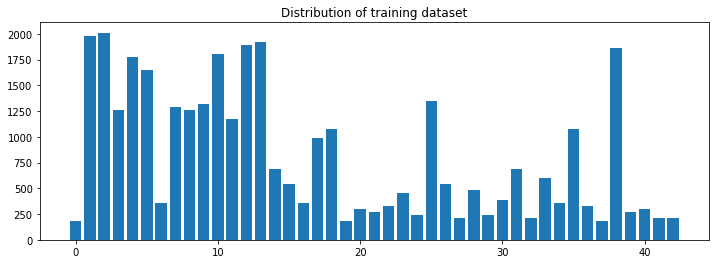

In [91]:
plt.figure(figsize=(12,4))
plt.bar(range(0,num_classes),num_of_samples)
plt.title("Distribution of training dataset")

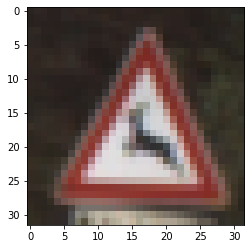

In [92]:
plt.imshow(X_train[500])

In [93]:
print(Y_train[500])

31


In [94]:
def grayscale(img):
  img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  return img


In [95]:
def equalize(img):
  img = cv2.equalizeHist(img)
  return img


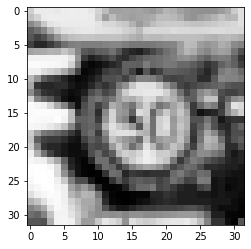

In [96]:
def preprocessing(img):
  img = grayscale(img)
  img = equalize(img)
  img = img/255
  return img
X_train = np.array(list(map(preprocessing,X_train)))
X_test = np.array(list(map(preprocessing,X_test)))
X_val = np.array(list(map(preprocessing,X_val)))
plt.imshow(X_train[random.randint(0,len(X_train)-1)],cmap = plt.get_cmap('gray'))

In [97]:
X_train = X_train.reshape(34799,32,32,1)
X_test = X_test.reshape(12630,32,32,1)
X_val = X_val.reshape(4410,32,32,1)

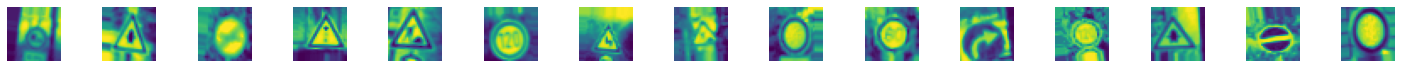

In [98]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(width_shift_range=0.1,height_shift_range=0.1,zoom_range=0.2,shear_range=0.1,rotation_range=10)
datagen.fit(X_train)
batches = datagen.flow(X_train,Y_train,batch_size=20)
X_batch,Y_batch = next(batches)
fig,ax = plt.subplots(1,15,figsize=(20,5))
fig.tight_layout()
for i in range(15):
  ax[i].imshow(X_batch[i].reshape(32,32))
  ax[i].axis('off')


In [99]:
Y_train = to_categorical(Y_train,43)
Y_test = to_categorical(Y_test,43)
Y_val = to_categorical(Y_val,43)

In [100]:
def traffic_model():
  model = Sequential()
  model.add(Conv2D(60,(5,5),input_shape=(32,32,1),activation='relu'))
  model.add(Conv2D(60,(5,5),activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Conv2D(30,(3,3),activation='relu'))
  model.add(Conv2D(30,(3,3),activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  
  model.add(Flatten())
  model.add(Dense(500,activation='relu'))
  model.add(Dense(43,activation='softmax'))
  model.compile(Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
  return model
model = traffic_model()
print(model.summary())
m = model.fit_generator(datagen.flow(X_train,Y_train,batch_size = 25),steps_per_epoch = 1200,epochs = 10,validation_data = (X_val,Y_val), shuffle = 1)
score = model.evaluate(X_test,Y_test,verbose = 0)
print(score)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 28, 28, 60)        1560      
                                                                 
 conv2d_13 (Conv2D)          (None, 24, 24, 60)        90060     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 12, 12, 60)       0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 10, 10, 30)        16230     
                                                                 
 conv2d_15 (Conv2D)          (None, 8, 8, 30)          8130      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 4, 4, 30)         0         
 2D)                                                  

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


1200/1200 [==============================] - 14s 11ms/step - loss: 1.3321 - accuracy: 0.6214 - val_loss: 0.1916 - val_accuracy: 0.9367
Epoch 2/10
1200/1200 [==============================] - 13s 11ms/step - loss: 0.3338 - accuracy: 0.8974 - val_loss: 0.0937 - val_accuracy: 0.9717
Epoch 3/10
1200/1200 [==============================] - 14s 11ms/step - loss: 0.2112 - accuracy: 0.9362 - val_loss: 0.0934 - val_accuracy: 0.9744
Epoch 4/10
1200/1200 [==============================] - 14s 12ms/step - loss: 0.1676 - accuracy: 0.9469 - val_loss: 0.1238 - val_accuracy: 0.9626
Epoch 5/10
1200/1200 [==============================] - 13s 11ms/step - loss: 0.1415 - accuracy: 0.9557 - val_loss: 0.0736 - val_accuracy: 0.9785
Epoch 6/10
1200/1200 [==============================] - 13s 11ms/step - loss: 0.1144 - accuracy: 0.9636 - val_loss: 0.1217 - val_accuracy: 0.9669
Epoch 7/10
1200/1200 [==============================] - 13s 11ms/step - loss: 0.1136 - accuracy: 0.9643 - val_loss: 0.0636 - val_accura

Text(0.5, 0, 'epoch')

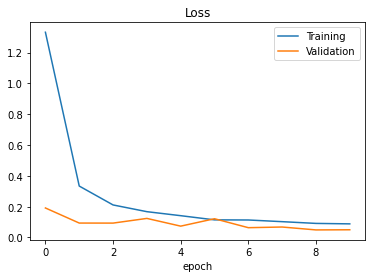

In [101]:
plt.plot(m.history['loss'])
plt.plot(m.history['val_loss'])
plt.legend(['Training','Validation'])
plt.title('Loss')
plt.xlabel('epoch')




Text(0.5, 0, 'epoch')

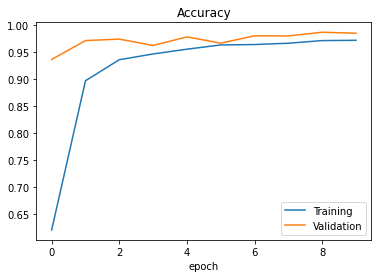

In [102]:
plt.plot(m.history['accuracy'])
plt.plot(m.history['val_accuracy'])
plt.legend(['Training','Validation'])
plt.title('Accuracy')
plt.xlabel('epoch')

Prediction is[22]


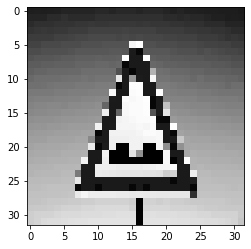

In [105]:
img = cv2.imread('/test.jpg')
resized = cv2.resize(img,(32,32))
gray = preprocessing(resized)
plt.imshow(gray,cmap = plt.get_cmap("gray"))
image = gray.reshape(1,32,32,1)
pred = np.argmax(model.predict(image), axis=-1)
print("Prediction is"+str(pred))